<a href="https://colab.research.google.com/github/Sparshj8287/ML_Journey/blob/main/07_milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-859530c8-2ec6-3d01-7696-01f6fec5a143)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-03 09:37:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-03 09:37:47 (109 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves,compare_historys

In [ ]:
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True, 
                                             with_info=True)

In [ ]:
class_names=ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
ds_info.features


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_one_sample=train_data.take(1)


In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 288, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 93
  Class name (str form): steak
        


In [ ]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

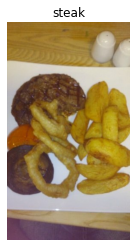

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [ ]:
def preprocess_train(image,label,img_shape=224):
  image=tf.image.resize(image,[img_shape,img_shape])
  image=image/255.
  return tf.cast(image,tf.float32),label

In [ ]:
preprocessed_image=preprocess_train(image,label)[0]

In [ ]:
preprocessed_image.shape

TensorShape([224, 224, 3])

In [ ]:
preprocessed_image.dtype

tf.float32

In [ ]:
train_data = train_data.map(map_func=preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
from helper_functions import create_tensorboard_callback
checkpoint_path="model_checkpoints/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=0) 

In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [ ]:
from tensorflow.keras import layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)


model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
tf.get_logger().setLevel('ERROR')
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs", 
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230303-100845
Epoch 1/3
2368/2368 [==============================] - 203s 81ms/step - loss: 4.7009 - accuracy: 0.0096 - val_loss: 4.7013 - val_accuracy: 0.0106
Epoch 2/3
2368/2368 [==============================] - 179s 75ms/step - loss: 4.6938 - accuracy: 0.0107 - val_loss: 4.6745 - val_accuracy: 0.0109
Epoch 3/3
2368/2368 [==============================] - 187s 78ms/step - loss: 4.6851 - accuracy: 0.0109 - val_loss: 4.6894 - val_accuracy: 0.0122
